In [26]:
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm
from google.colab.patches import cv2_imshow 
from tensorflow import keras
from tensorflow.keras import layers,models
import pickle

dir_path = '/content/drive/MyDrive/CV-HW-images/CV_A3/'

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

# Data Generation

## Part 1 : Creating A Mask using the TSS algorithm

In [27]:
# def TSS(img):
#   min_sum = -1
#   ans = 0
#   f_img = img.flatten()
#   for t in range(1,256):

#     fg = []
#     bg = []

#     fg = f_img[f_img>t]
#     bg = f_img[f_img<=t]

#     tss_fg,tss_bg = 0,0

#     if len(fg)>0:
#       fg_mean = np.mean(fg)
#       tss_fg = np.sum(np.square(fg - fg_mean))

#     if len(bg)>0:
#       bg_mean = np.mean(bg)
#       tss_bg = np.sum(np.square(bg - bg_mean))

#     if tss_fg+tss_bg < min_sum or min_sum==-1:
#       min_sum=tss_fg+tss_bg
#       ans = t

#   return ans

# y_train_mask = []
# y_test_mask = []

# for i in tqdm(range(len(x_train)),position=0,leave=True):
#   img = x_train[i]
#   _,thre_img =  cv2.threshold(img,TSS(img),255,cv2.THRESH_BINARY)
#   y_train_mask.append(thre_img)

# for i in tqdm(range(len(x_test)),position=0,leave=True):
#   img = x_test[i]
#   _,thre_img =  cv2.threshold(img,TSS(img),255,cv2.THRESH_BINARY)
#   y_test_mask.append(thre_img)

# y_train_mask = np.array(y_train_mask)//255
# y_test_mask = np.array(y_test_mask)//255

# pickle.dump(y_train_mask,open('/content/drive/MyDrive/CV-HW-images/CV_A3/MNIST_DATSET/y_train_mask.pkl','wb'))
# pickle.dump(y_test_mask,open('/content/drive/MyDrive/CV-HW-images/CV_A3/MNIST_DATSET/y_test_mask.pkl','wb'))

y_train_mask = pickle.load(open('/content/drive/MyDrive/CV-HW-images/CV_A3/MNIST_DATSET/y_train_mask.pkl','rb'))
y_test_mask = pickle.load(open('/content/drive/MyDrive/CV-HW-images/CV_A3/MNIST_DATSET/y_test_mask.pkl','rb'))

print(y_train_mask.shape,y_test_mask.shape)
cv2_imshow(x_train[0]) 
cv2_imshow(y_train_mask[0]*255)

(60000, 28, 28) (10000, 28, 28)


## Part 2 : Obtaing tight groundtruth circles around the foreground segmentation masks obtained in the previous block

In [28]:


y_train_circalization = []
y_test_circalization = []

for img in y_train_mask:
  contour,h = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  c,r = cv2.minEnclosingCircle(contour[0])

  y_train_circalization.append([r,c[0],c[1]])

for img in y_test_mask:
  contour,h = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  c,r = cv2.minEnclosingCircle(contour[0])

  y_test_circalization.append([r,c[0],c[1]])

y_train_circalization = np.array(y_train_circalization)
y_test_circalization = np.array(y_test_circalization)

y_train_circalization.shape,y_test_circalization.shape

cv2_imshow(y_train_mask[0]*255)
cv2_imshow(cv2.circle(y_train_mask[0]*255,tuple(map(round,y_train_circalization[0][1:])),round(y_train_circalization[0][1]),color = (200)))

## Part 3 : Randomly concatenating 4 images and their corresponding groundtruths obtained in first part, along with the pre-existing labels, in a 2x2 manner to develop new images and semantic segmentation groundtruths, respectively.

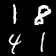

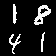

In [29]:
import random
random.seed(0)

def concat_4(originals):
  a,b,c,d = originals
  t1 = np.concatenate((a,b),axis=1)
  t2 = np.concatenate((c,d),axis=1)
  return np.concatenate((t1,t2))

def make_datapoint(originals,labels,masks):
  new_x = concat_4(originals)
  new_y = []
  for i in range(4):
    new_y.append(masks[i]*(labels[i]+1))
  new_y = concat_4(new_y)
  
  return new_x,new_y

train_shuffler = np.random.permutation(len(x_train))
test_shuffler = np.random.permutation(len(x_test))

shuffled_x_train = x_train[train_shuffler]
shuffled_y_train = y_train[train_shuffler]

shuffled_y_train_mask = y_train_mask[train_shuffler]
shuffled_y_test_mask = y_test_mask[test_shuffler]

shuffled_x_test = x_test[test_shuffler]
shuffled_y_test = y_test[test_shuffler]

large_x_train = []
large_x_test = []
large_y_train = []
large_y_test = []

for i in range(0,len(x_train),4):
  originals = shuffled_x_train[i:i+4]
  labels = shuffled_y_train[i:i+4]
  masks = shuffled_y_train_mask[i:i+4]
  new_x,new_y = make_datapoint(originals,labels,masks)

  large_x_train.append(new_x)
  large_y_train.append(new_y)

  # ----------------

  if i<len(x_test):
    originals = shuffled_x_test[i:i+4]
    labels = shuffled_y_test[i:i+4]
    masks = shuffled_y_test_mask[i:i+4]
    new_x,new_y = make_datapoint(originals,labels,masks)

    large_x_test.append(new_x)
    large_y_test.append(new_y)


large_x_train = np.array(large_x_train)
large_x_test = np.array(large_x_test)
large_y_train = np.array(large_y_train)
large_y_test = np.array(large_y_test)


large_x_train.shape,large_x_test.shape

cv2_imshow(large_x_train[0])
print(' ',end = '')
cv2_imshow(large_y_train[0]*255)

# Model Construction & Training

## Training a DL network from scratch for performing foreground extraction on the new dataset obtained in Part 1.

In [30]:
class MyJaccardMetric(tf.keras.metrics.MeanIoU):
  def update_state(self,y_true,y_pred,sample_weight=None):
    output = tf.math.argmax(y_pred,axis=3)
    return super().update_state(y_true,output)


model_Q2 = models.Sequential([
      layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),input_shape = (28,28,1),activation='relu',padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2DTranspose(32,(2,2),(2,2),activation='relu'),
      layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2DTranspose(16,(2,2),(2,2),activation='relu'),
      layers.Conv2D(2,kernel_size=(3,3),strides=(1,1),padding='same'),
      layers.Softmax(axis=3)
])

model_Q2.compile(optimizer='adam',
              loss = keras.losses.sparse_categorical_crossentropy,
              metrics  = ['accuracy',MyJaccardMetric(num_classes = 2)])

model_Q2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 32)       

In [31]:
history_Q2 = model_Q2.fit(x = x_train.reshape((-1, 28, 28, 1))/255,
                          y = y_train_mask,
                          batch_size = 128,
                          epochs = 50,
                          validation_data=(x_test.reshape((-1, 28, 28, 1))/255, y_test_mask))

Epoch 1/50
469/469 [==============================] - 12s 23ms/step - loss: 0.1133 - accuracy: 0.9506 - my_jaccard_metric_4: 0.8083 - val_loss: 0.0439 - val_accuracy: 0.9814 - val_my_jaccard_metric_4: 0.9288
Epoch 2/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0385 - accuracy: 0.9840 - my_jaccard_metric_4: 0.9364 - val_loss: 0.0352 - val_accuracy: 0.9851 - val_my_jaccard_metric_4: 0.9420
Epoch 3/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0331 - accuracy: 0.9862 - my_jaccard_metric_4: 0.9447 - val_loss: 0.0307 - val_accuracy: 0.9871 - val_my_jaccard_metric_4: 0.9491
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0301 - accuracy: 0.9874 - my_jaccard_metric_4: 0.9494 - val_loss: 0.0284 - val_accuracy: 0.9882 - val_my_jaccard_metric_4: 0.9527
Epoch 5/50
469/469 [==============================] - 10s 22ms/step - loss: 0.0284 - accuracy: 0.9881 - my_jaccard_metric_4: 0.9521 - val_loss: 0.0277 - val_accuracy: 0

In [33]:
loss_Q2,Accuracy_Q2,Jaccard_Q2 = model_Q2.evaluate(x = x_test.reshape((-1, 28, 28, 1))/255,y = y_test_mask)

print('\nloss_Q2     = %.3f' % loss_Q2)
print('Accuracy_Q2 = %.3f%%' % (Accuracy_Q2*100))
print('Jaccard_Q2  = %.3f' % Jaccard_Q2)

model_Q2.save('/content/drive/MyDrive/CV-HW-images/CV_A3/Foreground_Extraction')

313/313 [==============================] - 2s 7ms/step - loss: 0.0155 - accuracy: 0.9936 - my_jaccard_metric_4: 0.9741

loss_Q2     = 0.015
Accuracy_Q2 = 99.364%
Jaccard_Q2  = 0.974
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV-HW-images/CV_A3/Foreground_Extraction/assets


## Traning a DL network from scratch for performing classification with circlization on the new dataset obtained in Part : 2 and reporting the test performance using Jaccard Similarity on the circles.

Model: "Q3_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 26, 26, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 13, 13, 16)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 11, 11, 32)   4640        max_pooling2d_8[0][0]            
___________________________________________________________________________________________

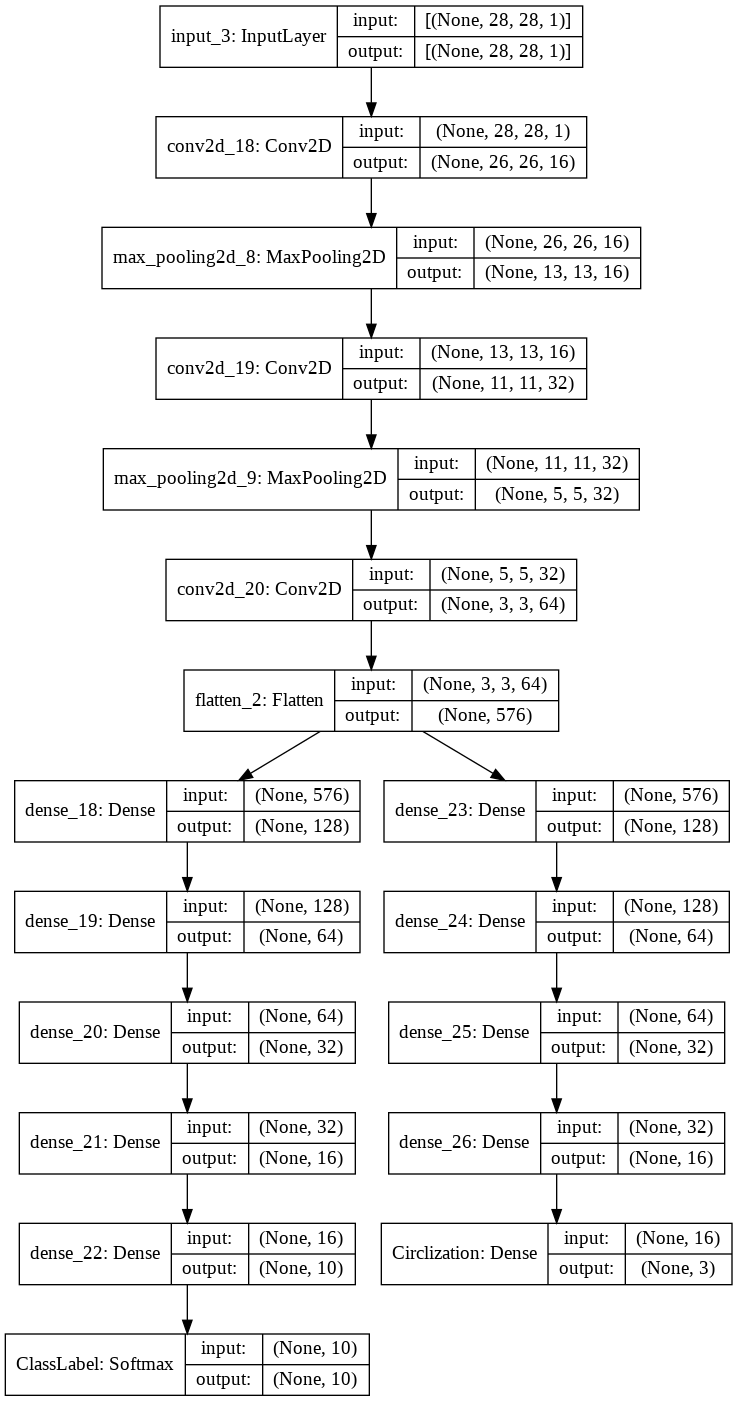

In [19]:
def get_model_3():
  input = keras.Input(shape = (28,28,1)) 
  x = layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),input_shape = (28,28,1),activation='relu')(input)
  x = layer_2 = layers.MaxPool2D()(x)
  x = layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(x)
  x = layers.Flatten()(x)

  x1 = layers.Dense(128)(x)
  x1 = layers.Dense(64,activation='relu')(x1)
  x1 = layers.Dense(32,activation='relu')(x1)
  x1 = layers.Dense(16,activation='relu')(x1)
  x1 = layers.Dense(10,activation='relu')(x1)
  y_pred1 = layers.Softmax(name = 'ClassLabel')(x1)

  x2 = layers.Dense(128,activation='relu')(x)
  x2 = layers.Dense(64,activation='relu')(x2)
  x2 = layers.Dense(32,activation='relu')(x2)
  x2 = layers.Dense(16,activation='relu')(x2)
  y_pred2 = layers.Dense(3,name = 'Circlization')(x2)

  model = keras.Model(inputs = input,outputs = [y_pred1,y_pred2],name = 'Q3_model')

  model.compile(
      optimizer = 'adam',
      loss = {
          'ClassLabel' : keras.losses.sparse_categorical_crossentropy,
          'Circlization':  keras.losses.MSE
      },
      loss_weights = [1.0,1.0],
      metrics = {
          'ClassLabel' : ['accuracy']
      }
  )

  return model

model_Q3 = get_model_3()
model_Q3.summary()
keras.utils.plot_model(model_Q3,show_shapes=True)

In [20]:
model_Q3.fit( x = x_train.reshape((-1, 28, 28, 1))/255,
              y = [y_train,
                   y_train_circalization],
              batch_size = 60,
              epochs = 30)

Epoch 1/30
1000/1000 [==============================] - 8s 7ms/step - loss: 5.4403 - ClassLabel_loss: 0.8445 - Circlization_loss: 4.5959 - ClassLabel_accuracy: 0.7103
Epoch 2/30
1000/1000 [==============================] - 7s 7ms/step - loss: 2.0504 - ClassLabel_loss: 0.2217 - Circlization_loss: 1.8287 - ClassLabel_accuracy: 0.9306
Epoch 3/30
1000/1000 [==============================] - 7s 7ms/step - loss: 1.8644 - ClassLabel_loss: 0.1280 - Circlization_loss: 1.7364 - ClassLabel_accuracy: 0.9603
Epoch 4/30
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7818 - ClassLabel_loss: 0.0992 - Circlization_loss: 1.6825 - ClassLabel_accuracy: 0.9685
Epoch 5/30
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7307 - ClassLabel_loss: 0.0778 - Circlization_loss: 1.6529 - ClassLabel_accuracy: 0.9758
Epoch 6/30
1000/1000 [==============================] - 7s 7ms/step - loss: 1.6830 - ClassLabel_loss: 0.0666 - Circlization_loss: 1.6165 - ClassLabel_accuracy: 0.979

In [21]:
temp = model_Q3.evaluate(x = x_test.reshape((-1, 28, 28, 1))/255,
                         y = [y_test,
                              y_test_circalization])

y_pred_labels,y_pred_circles = model_Q3.predict(x_test.reshape((-1, 28, 28, 1))/255)

y_pred_labels = np.argmax(y_pred_labels,axis = 1)

Similarity = []

def dist(x1,y1,x2,y2):
  return (((x1-x2)**2) + ((y1-y2)**2))**0.5

for i in range(len(y_pred_labels)):

  if y_pred_labels[i]!=y_test[i]:
    Similarity.append(0)
  else:
    pred_center = y_pred_circles[i,1:]
    pred_radius = y_pred_circles[i,0]

    actual_center = y_test_circalization[i,1:]
    actual_radius = y_test_circalization[i,0]

    union = 0
    intersection = 0

    for i in range(28):
      for j in range(28):
        t = 0
        if dist(i,j,pred_center[0],pred_center[1]) <= pred_radius: t+=1
        if dist(i,j,actual_center[0],actual_center[1]) <= actual_radius: t+=1

        if t>=1: union+=1
        if t==2: intersection+=1
    
    if intersection>0: jd = intersection/union
    Similarity.append(jd)


print('Jaccard Similarity :',np.mean(np.array(Similarity)))

model_Q3.save('/content/drive/MyDrive/CV-HW-images/CV_A3/Circlization')

313/313 [==============================] - 2s 4ms/step - loss: 1.2322 - ClassLabel_loss: 0.0631 - Circlization_loss: 1.1690 - ClassLabel_accuracy: 0.9854
Jaccard Similarity : 0.8448983859294616
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV-HW-images/CV_A3/Circlization/assets


## Traning a DL network from scratch for performing image segmentation into 11 labels [ 1 background + 10 numbers ] and reporting testing results using jaccard similarity 

In [23]:
model_Q4 = models.Sequential([
      layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),input_shape = (56,56,1),activation='relu',padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2DTranspose(32,(2,2),(2,2),activation='relu'),
      layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
      layers.Conv2DTranspose(16,(2,2),(2,2),activation='relu'),
      layers.Conv2D(11,kernel_size=(3,3),strides=(1,1),padding='same'),
      layers.Softmax(axis=3)
])

model_Q4.compile(optimizer='adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics  = ['accuracy',MyJaccardMetric(num_classes=11)],)

model_Q4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 56, 56, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)       

In [24]:
history_Q4 = model_Q4.fit(x = large_x_train.reshape((-1, 56, 56, 1))/255,
                    y = large_y_train,
                    batch_size = 60,
                    epochs = 30)

Epoch 1/30
250/250 [==============================] - 9s 29ms/step - loss: 0.6326 - accuracy: 0.8559 - my_jaccard_metric_3: 0.0899
Epoch 2/30
250/250 [==============================] - 7s 28ms/step - loss: 0.3410 - accuracy: 0.8835 - my_jaccard_metric_3: 0.1954
Epoch 3/30
250/250 [==============================] - 7s 28ms/step - loss: 0.2680 - accuracy: 0.9062 - my_jaccard_metric_3: 0.3177
Epoch 4/30
250/250 [==============================] - 7s 28ms/step - loss: 0.2072 - accuracy: 0.9280 - my_jaccard_metric_3: 0.4490
Epoch 5/30
250/250 [==============================] - 7s 28ms/step - loss: 0.1570 - accuracy: 0.9461 - my_jaccard_metric_3: 0.5729
Epoch 6/30
250/250 [==============================] - 7s 28ms/step - loss: 0.1305 - accuracy: 0.9550 - my_jaccard_metric_3: 0.6416
Epoch 7/30
250/250 [==============================] - 7s 28ms/step - loss: 0.1138 - accuracy: 0.9607 - my_jaccard_metric_3: 0.6871
Epoch 8/30
250/250 [==============================] - 7s 28ms/step - loss: 0.1018 -

In [25]:
loss_Q4,Accuracy_Q4,Jaccard_Q4 = model_Q4.evaluate(x = large_x_test.reshape((-1, 56, 56, 1))/255,y = large_y_test)

print('\nloss_Q4     = %.3f' % (loss_Q4))
print('Accuracy_Q4 = %.3f%%' % (Accuracy_Q4*100))
print('Jaccard_Q4  = %.3f' % Jaccard_Q4)

model_Q3.save('/content/drive/MyDrive/CV-HW-images/CV_A3/Image_Segmentation')

79/79 [==============================] - 1s 12ms/step - loss: 0.0469 - accuracy: 0.9822 - my_jaccard_metric_3: 0.8697

loss_Q4     = 0.047
Accuracy_Q4 = 98.221%
Jaccard_Q4  = 0.870
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV-HW-images/CV_A3/Image_Segmentation/assets
